In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 🔴 **Import Libs**

In [1]:
pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [64]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import cv2 as cv
import PIL
from PIL import Image
import face_detection
import cv2
import time

import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF
import torchvision.models as models
from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights

import tqdm
import torchmetrics as tm

In [3]:
!python --version

Python 3.11.8


In [4]:
for lib in [np, pd, cv, PIL, sklearn, torch, torchvision, tqdm, tm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
pandas --> 2.2.1
cv2 --> 4.10.0
PIL --> 10.4.0
sklearn --> 1.4.2
torch --> 2.2.1
torchvision --> 0.17.1
tqdm --> 4.65.0
torchmetrics --> 1.4.0


# 🔴 **Utils**

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [34]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [54]:
def draw_faces(im, bboxes):
    model_path = 'E:\\My Drive\\deepcatalist\\model.pt'
    model = torch.load(model_path, map_location=torch.device(device))
    model.eval()
    for bbox in bboxes:
        x0, y0, x1, y1 = [int(_) for _ in bbox]
        cv2.rectangle(im, (x0, y0), (x1, y1), (0, 0, 255), 2)
        img = TF.to_tensor(im[x0:x1, y0:y1]).unsqueeze(0)
        age = int(model(img).item())
        label = f'age:{age}'
        (w, h), _ = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
        cv2.putText(im, label, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

# 🔴 **Dataset**

## 🟠 EDA

### 🟡 Let's explore the images in the UTK dataset together!

🔰 Download the UFTK dataset to your computer:


*   explore it
*   then list five observations or interesting characteristics you find in the dataset.



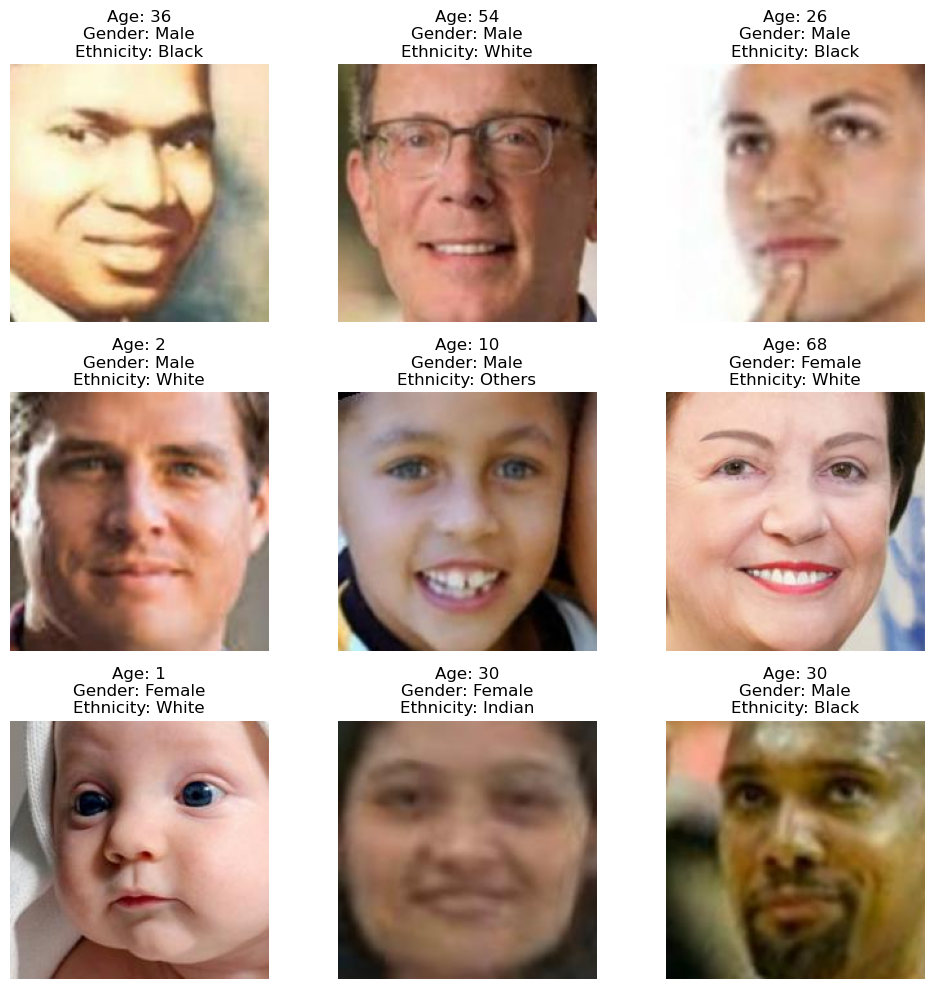

In [11]:
# Replace with the actual path to your UTK dataset images folder
dataset_folder = 'E:\\My Drive\\deepcatalist\\utkcropped\\'

def show_random_samples(num_samples=9):
    image_files = os.listdir(dataset_folder)
    selected_image_files = random.sample(image_files, num_samples)

    plt.figure(figsize=(10, 10))
    for idx, image_file in enumerate(selected_image_files, 1):
        image_path = os.path.join(dataset_folder, image_file)
        age, gender, ethnicity = image_file.split('_')[:3]

        image = Image.open(image_path)

        gender = 'Male' if int(gender) == 0 else 'Female'
        ethnicity = ['White', 'Black', 'Asian', 'Indian', 'Others'][int(ethnicity)]

        plt.subplot(3, 3, idx)
        plt.imshow(image)
        plt.title(f"Age: {age}\nGender: {gender}\nEthnicity: {ethnicity}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display random samples
show_random_samples()


### 🟡 Create a csv file which contains labels

In [12]:
dataset_folder = 'E:\\My Drive\\deepcatalist\\utkcropped\\'
image_name = os.listdir(dataset_folder)
count = 0
for i in image_name:
    age = int(i.split('_')[0])
    gender = i.split('_')[1]
    ethnicity = i.split('_')[2]
    if gender not in ['0', '1'] or ethnicity not in ['0', '1', '2', '3', '4'] or age>80:
        os.remove(os.path.join(dataset_folder, i))
        count += 1
    else:
        pass
print(f'deleted {count} images from root')

deleted 0 images from root


In [13]:
dataset_folder = 'E:\\My Drive\\deepcatalist\\utkcropped\\'
image_name = os.listdir(dataset_folder)
age = [int(i.split('_')[0]) for i in image_name]
gender = [['Male', 'Female'][int(i.split('_')[1])] for i in image_name]
ethnicity = [['White', 'Black', 'Asian', 'Indian', 'Others'][int(i.split('_')[2])] for i in image_name]
dataset = pd.DataFrame({'image_name':image_name, 'age':age, 'ethnicity':ethnicity, 'gender':gender})

dataset.to_csv('E:\\My Drive\\deepcatalist\\utkface_dataset.csv')

### 🟡 Plot histogram for age

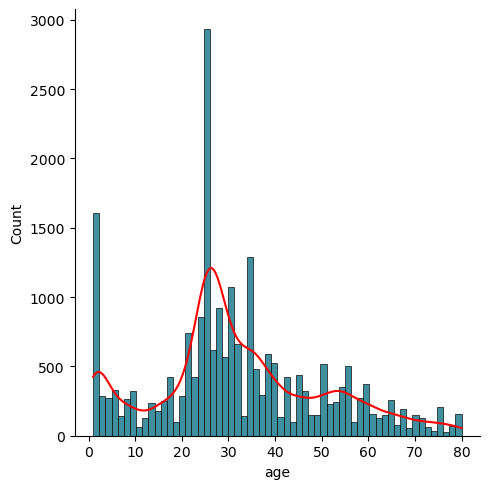

In [14]:
sns.displot(data=dataset['age'], kde=True, color='red', facecolor='#3F8F9F')

#### 🛑 **Tip:** You can use Plotly or Seaborn libraries to create visually appealing plots!

### 🟡 Plot histogram for gender

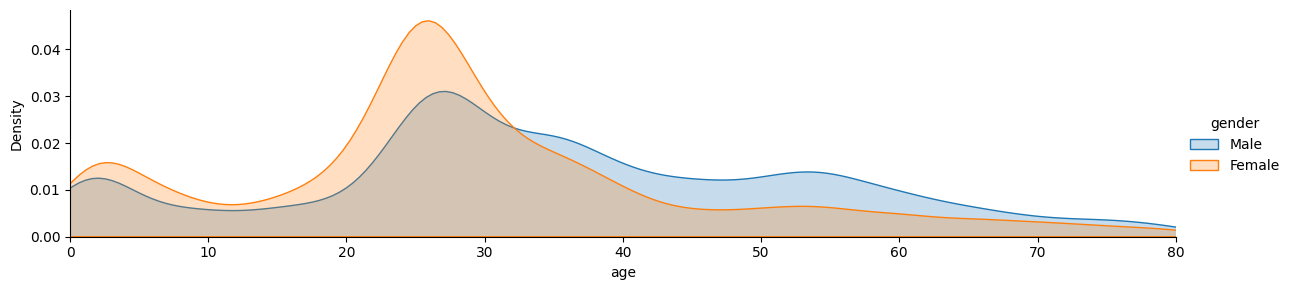

In [ ]:
fig = sns.FacetGrid(dataset, hue='gender', aspect=4)
fig.map(sns.kdeplot, 'age', fill=True)
oldest = dataset['age'].max()
fig.set(xlim=(0, oldest))
fig.add_legend()
plt.show()

### 🟡 Plot histogram for ethnicity

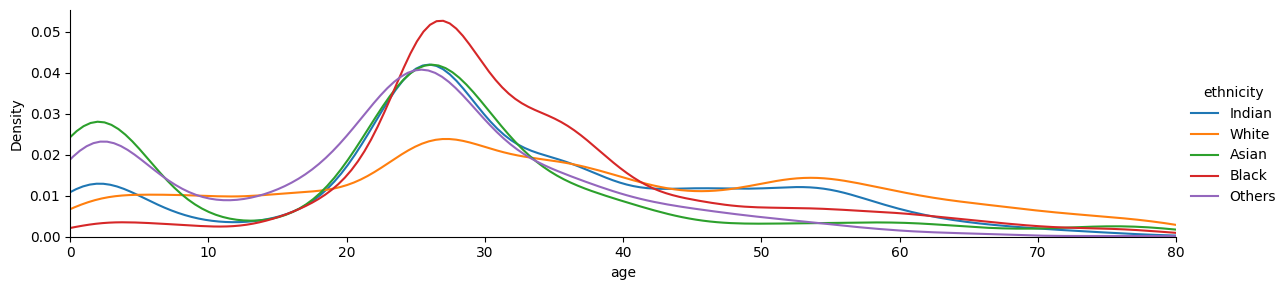

In [ ]:
fig = sns.FacetGrid(dataset, hue='ethnicity', aspect=4)
fig.map(sns.kdeplot, 'age')
oldest = dataset['age'].max()
fig.set(xlim=(0, oldest))
fig.add_legend()
plt.show()

### 🟡 Calculate the cross-tabulation of gender and ethnicity using the pandas.crosstab() function.

In [ ]:
tab = pd.crosstab(dataset['ethnicity'], dataset['gender'], rownames=['ethnicity'], colnames=['gender'])
tab

gender,Female,Male
ethnicity,,
Asian,1810,1538
Black,2182,2296
Indian,1698,2254
Others,930,759
White,4337,5361


<Axes: xlabel='gender', ylabel='count'>

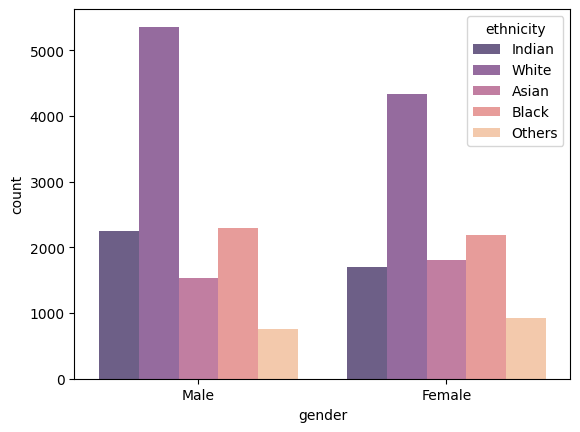

In [ ]:
sns.countplot(x=dataset['gender'], hue=dataset['ethnicity'], palette='magma', alpha=0.7)

### 🟡 Create violin plots and box plots for age, separately for men and women.

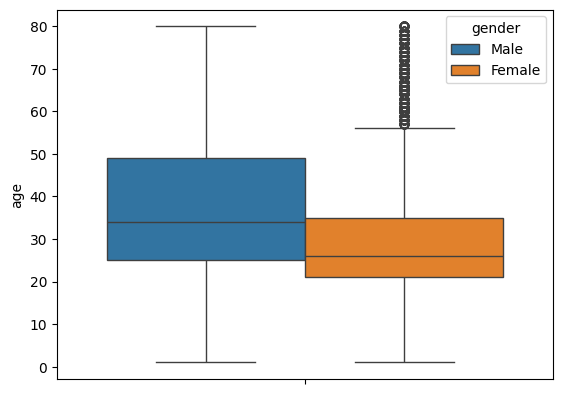

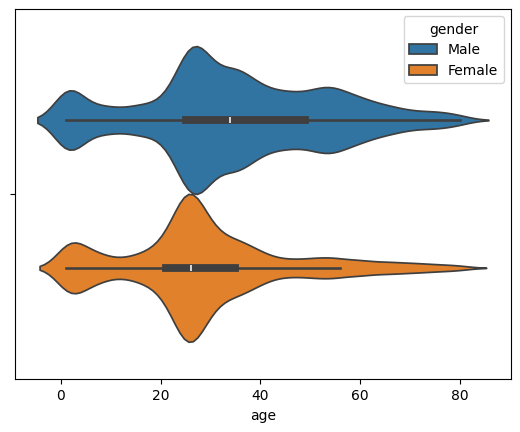

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

sns.boxplot(data=dataset, y='age', hue='gender')
plt.show()
sns.violinplot(data=dataset, hue='gender', x='age')
plt.show()

### 🟡 Create violin plots and box plots for age, separately for each ethnicity.

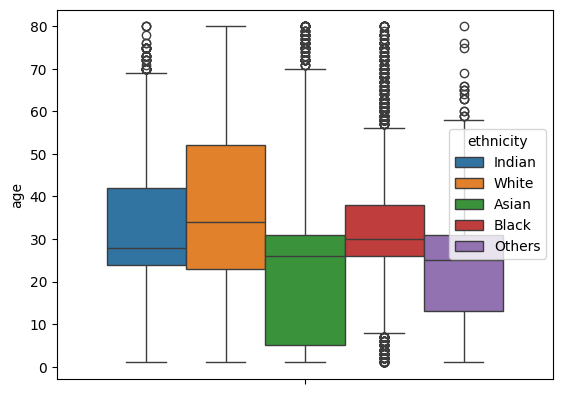

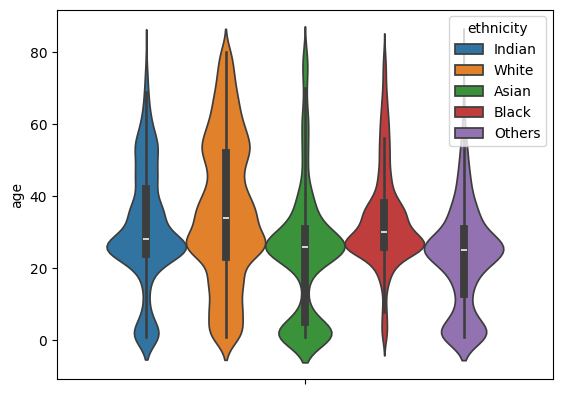

In [ ]:
sns.boxplot(data=dataset, y='age', hue='ethnicity')
plt.show()
sns.violinplot(data=dataset, hue='ethnicity', y='age')
plt.show()

## 🟠 Split datasets

🔰 use scikit-learn's train_test_split function to partition the dataset into training, validation, and test sets.

In [15]:
train, df_test = train_test_split(dataset, test_size=0.3, stratify=dataset['age'])
df_train, df_valid = train_test_split(train, test_size=0.2, stratify=train['age'])

In [16]:
df_train.shape, df_valid.shape, df_test.shape

((12972, 4), (3243, 4), (6950, 4))

###🟡 Plot histograms for age in the training, validation, and test sets.

⛔️ **Warning:** Ensure that the distributions of the training, validation, and test sets are similar.

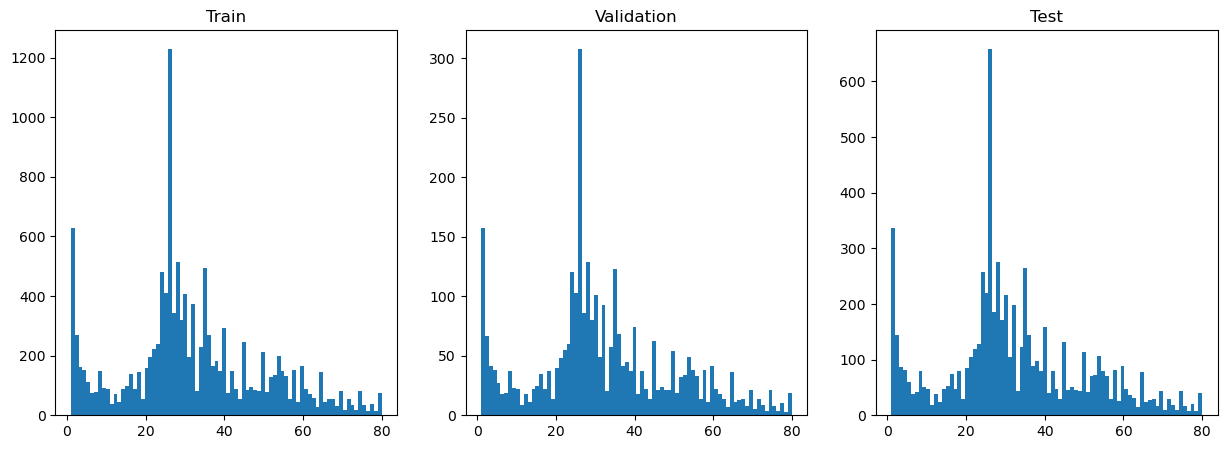

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df_train.age, bins=len(df_train.age.unique())); axes[0].set_title('Train')
axes[1].hist(df_valid.age, bins=len(df_valid.age.unique())); axes[1].set_title('Validation')
axes[2].hist(df_test.age, bins=len(df_test.age.unique())); axes[2].set_title('Test');

### 🟡 Save the training, validation, and test sets in separate CSV files.

In [18]:
df_train.to_csv('E:\\My Drive\\deepcatalist\\train_set.csv', index=False)
df_valid.to_csv('E:\\My Drive\\deepcatalist\\valid_set.csv', index=False)
df_test.to_csv('E:\\My Drive\\deepcatalist\\test_set.csv', index=False)

print('All CSV files created successfully.')

All CSV files created successfully.


## 🟠 Define transformations

🔰 implement a data transformation pipeline using PyTorch's transforms.
The transformations include:

*   Resizing images to a resolution of 128x128 pixels.
*   Applying random horizontal flips to the images.
*   Introducing random rotations of 15 degrees.
*   Adjusting image color using the ColorJitter transformation.
*   Converting the images to tensors.
*   Normalizing the pixel values using the provided mean and standard deviation values `(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`.

In [41]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

## 🟠 Custom dataset

🔰 Write a custom dataset class for UTKFace.

In [20]:
class UTKDataset(Dataset):

    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.gender_dict = {'Male':0, "Female":1}
        self.ethnicity_dict = {'White':0, 'Black':1, 'Asian':2, 'Indian':3, 'Others':4}

        self.file = pd.read_csv(csv_file)


    def __len__(self):
        return len(self.file)

    def __getitem__(self, idx):
        sample = self.file.iloc[idx, :]
        img_path = os.path.join(self.root_dir, sample.image_name)
        img = Image.open(img_path).convert('RGB')
        image = self.transform(img)
        age = torch.tensor(sample.age, dtype=torch.float32)
        gender = torch.tensor(self.gender_dict[sample.gender], dtype=torch.int32)
        ethnicity = torch.tensor(self.ethnicity_dict[sample.ethnicity], dtype=torch.int32)
        return image, age #gender, ethnicity

🔰 Utilize the UTKDataset class you've created to instantiate dataset objects for the training, validation, and test sets.

In [21]:
train = UTKDataset('E:\\My Drive\\deepcatalist\\utkcropped\\', 'E:\\My Drive\\deepcatalist\\train_set.csv', train_transform)
valid = UTKDataset('E:\\My Drive\\deepcatalist\\utkcropped\\', 'E:\\My Drive\\deepcatalist\\valid_set.csv', test_transform)
test = UTKDataset('E:\\My Drive\\deepcatalist\\utkcropped\\', 'E:\\My Drive\\deepcatalist\\test_set.csv', test_transform)

🔰 Plot a few images to verify the functionality of the dataset objects.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


age:39.0


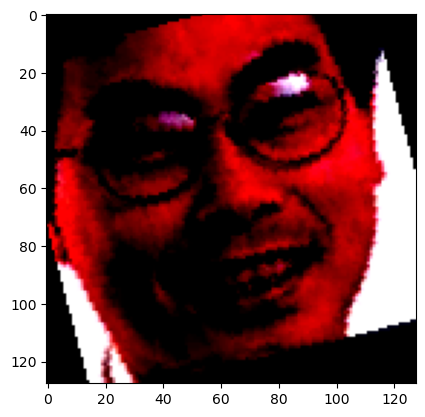

In [22]:
x, age = train.__getitem__(1)
plt.imshow(x.permute(1, 2, 0).numpy())
print(f'age:{age}')

## 🟠 Define dataloader

🔰 Write dataloaders for the training, validation, and test sets.

In [23]:
train_loader = DataLoader(train, 32, True)
valid_loader = DataLoader(valid, 64, False)
test_loader = DataLoader(test, 64, False)

🔰 Test the dataloaders using `next(iter())`

In [24]:
x, age = next(iter(train_loader))
x.shape, age

(torch.Size([32, 3, 128, 128]),
 tensor([ 2., 31., 35., 55., 26., 26., 57., 36., 58., 26., 69., 54., 29.,  5.,
         29., 40., 30.,  1., 30., 19., 32.,  1., 44., 26.,  1., 30., 62., 76.,
         45., 65., 24., 55.]))

# 🔴 **Model**

🔰 Use the following template to create a custom model employing the ResNet-50 architecture

In [26]:
resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
class AgeEstimationModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Identity()
        self.fc = nn.Linear(in_features=512, out_features=1, bias=True)


    def forward(self, x):
        y = self.fc(self.model(x))
        return y

🔰 Create an object for model using the AgeEstimationModel class you've created.

# 🔴 **Config**

🔰 Define the optimizer, loss function, and metrics in this section, and ensure the model is sent to the appropriate device.

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AgeEstimationModel().to(device)

loss_fn = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [29]:
metric = tm.MeanAbsoluteError()

# 🔴 **Train ➰**

🔰Write the train function.

In [30]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
    model.train()
    metric.reset()
    with tqdm.tqdm(train_loader, unit="batch") as tepoch:
        for inputs, targets in tepoch:
            if epoch is not None:
                tepoch.set_description(f"Epoch {epoch}")
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs).to(device)

            loss = loss_fn(outputs, targets.unsqueeze(1))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            metric.update(outputs, targets.unsqueeze(1))
            tepoch.set_postfix(loss=metric.compute().item())
    return model, metric.compute().item()


# 🔴 **Evaluation ➰**

In [31]:
def evaluate(model, test_loader, metric):
    model.eval()
    metric.reset()
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        metric.update(outputs, targets.unsqueeze(1))
    return metric.compute().item()

🔰Write the evaluation function.

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [33]:
model = AgeEstimationModel().to(device)
model.model.requires_grad_(True)
model.fc.requires_grad_(True)

loss_fn = nn.L1Loss()
x_batch, y_batch = next(iter(train_loader))
x_batch = x_batch.to(device)
y_batch = y_batch.to(device)
with torch.no_grad():
  output = model(x_batch)
loss_fn(output, y_batch.unsqueeze(1))

tensor(27.6472)

### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = AgeEstimationModel().to(device)
loss_fn = nn.L1Loss()

metric = tm.MeanAbsoluteError().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01)
mini_set, _ = random_split(train, (100, train.__len__()-100))
mini_loader = DataLoader(mini_set, 20, False)
for epoch in range(30):
    _, loss = train_one_epoch(model, mini_loader, loss_fn, optimizer, metric, epoch)


Epoch 29: 100%|██████████| 5/5 [00:01<00:00,  4.68batch/s, loss=3.39]


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
torch.cuda.empty_cache()

In [ ]:
lrs = [0.1, 0.05, 0.01]
for lr in lrs:
    print(f'lr = {lr}')
    model = AgeEstimationModel().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    metric = tm.MeanAbsoluteError().to(device)

    for epoch in range(2):
        _, loss = train_one_epoch(model, mini_loader, loss_fn, optimizer, metric, epoch)
    torch.cuda.empty_cache()

lr = 0.1


Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  5.65batch/s, loss=16.9]


lr = 0.05


Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  5.80batch/s, loss=15.4]


lr = 0.01


Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  5.79batch/s, loss=12.7]


### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [ ]:
from prettytable import PrettyTable

table = PrettyTable(['lr', 'wd', 'loss'])

In [ ]:
wd = [0, 1e-4, 1e-5]
lr = [0.02, 0.01, 0.005]
rows = []
for w in wd:
    for l in lr:
        print(f'wd = {w}  lr = {l}')
        model = AgeEstimationModel().to(device)
        optimizer = optim.SGD(model.parameters(), lr=l, weight_decay=w)
        for epoch in range(5):
            _, loss = train_one_epoch(model, mini_loader, loss_fn, optimizer, metric, epoch)
        rows.append([l, w, round(loss, 4)])

wd = 0  lr = 0.02


Epoch 4: 100%|██████████| 5/5 [00:01<00:00,  4.78batch/s, loss=10.8]


wd = 0  lr = 0.01


Epoch 4: 100%|██████████| 5/5 [00:00<00:00,  5.65batch/s, loss=8.75]


wd = 0  lr = 0.005


Epoch 4: 100%|██████████| 5/5 [00:00<00:00,  5.86batch/s, loss=9.52]


wd = 0.0001  lr = 0.02


Epoch 4: 100%|██████████| 5/5 [00:01<00:00,  4.66batch/s, loss=10.4]


wd = 0.0001  lr = 0.01


Epoch 4: 100%|██████████| 5/5 [00:00<00:00,  5.47batch/s, loss=10.3]


wd = 0.0001  lr = 0.005


Epoch 4: 100%|██████████| 5/5 [00:00<00:00,  5.65batch/s, loss=9.32]


wd = 1e-05  lr = 0.02


Epoch 4: 100%|██████████| 5/5 [00:00<00:00,  5.73batch/s, loss=9.83]


wd = 1e-05  lr = 0.01


Epoch 4: 100%|██████████| 5/5 [00:00<00:00,  5.72batch/s, loss=9.18]


wd = 1e-05  lr = 0.005


Epoch 4: 100%|██████████| 5/5 [00:01<00:00,  4.97batch/s, loss=9.55]


In [ ]:
for row in rows:
  table.add_row(row)

In [ ]:
print(table)

+-------+--------+---------+
|   lr  |   wd   |   loss  |
+-------+--------+---------+
|  0.02 |   0    | 10.8271 |
|  0.01 |   0    |  8.7468 |
| 0.005 |   0    |  9.5238 |
|  0.02 | 0.0001 | 10.4129 |
|  0.01 | 0.0001 | 10.2968 |
| 0.005 | 0.0001 |   9.32  |
|  0.02 | 1e-05  |  9.832  |
|  0.01 | 1e-05  |  9.1777 |
| 0.005 | 1e-05  |  9.553  |
+-------+--------+---------+


### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [ ]:
torch.cuda.empty_cache()

In [ ]:
# model = AgeEstimationModel().to(device)
model = torch.load('/content/drive/MyDrive/deepcatalist/model.pt', map_location=torch.device(device))

In [ ]:
# model.model.requires_grad_(True)
# model.model.layer4.requires_grad_(True)
# model.fc.requires_grad_(True)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
lr = 0.001
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
metric=tm.MeanAbsoluteError().to(device)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                    train_loader,
                                    loss_fn,
                                    optimizer,
                                    metric,
                                    epoch)
  # Validation
  loss_valid = evaluate(model,
                       valid_loader,
                       metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, '/content/drive/MyDrive/deepcatalist/model.pt')
    best_loss_valid = loss_valid
    print('model saved!')

  print(f'Valid: Loss = {loss_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0:   2%|▏         | 8/406 [02:45<2:17:01, 20.66s/batch, loss=4.63]


KeyboardInterrupt: 

## 🟠 Plot

🔰 Plot learning curves

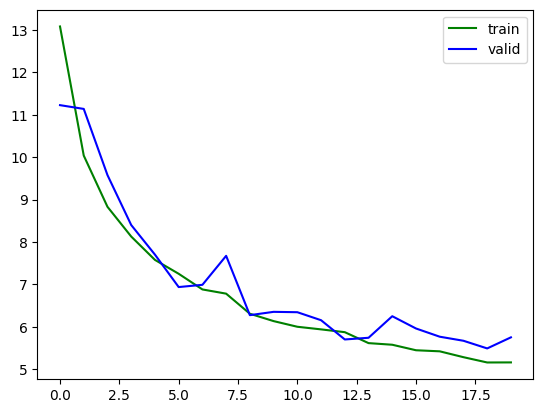

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'g', label='train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b', label='valid')
plt.legend()
plt.show()

# 🔴 **Test**

🔰 Test your model using data from the test set and images that are not present in the dataset.

In [ ]:
model_path = '/content/drive/MyDrive/deepcatalist/model.pt'
model = torch.load(model_path, map_location=torch.device(device))
model.eval()

AgeEstimationModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
metric_test = evaluate(model, test_loader, metric)
metric_test

4.213883876800537

# 🔴 **Webcam**

In [55]:
def Webcam():
    detector = face_detection.build_detector(
          "DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)
    cap = cv2.VideoCapture(0)
    while cap.isOpened():
        
        
        if cv2.waitKey(2) & 0xFF == ord('s'):
            while (cv2.waitKey(1) & 0xFF == ord('q')) == False:
                ret, frame = cap.read()
                frame = cv2.flip(frame, 1)
                cv2.putText(frame,  
                    'PRESS s to start',  
                    (10, 30),  
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6,  
                    (204, 0, 102),  
                    1,  
                    cv2.LINE_4)
                cv2.putText(frame,  
                    'PRESS q to quite',  
                    (10, 50),  
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6,  
                    (204, 0, 102),  
                    1,  
                    cv2.LINE_4)
                dets = detector.detect(
                        frame[:, :, ::-1]
                    )[:, :4]
                draw_faces(frame, dets) 
                cv2.imshow('video',frame)
            
            
        elif cv2.waitKey(1) & 0xFF == ord('q'):
            break
        else:
            ret, frame = cap.read()
            frame = cv2.flip(frame, 1)
            cv2.putText(frame,  
                    'PRESS s to start',  
                    (10, 30),  
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6,  
                    (204, 0, 102),  
                    1,  
                    cv2.LINE_4)
            cv2.putText(frame,  
                    'PRESS q to quite',  
                    (10, 50),  
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6,  
                    (204, 0, 102),  
                    1,  
                    cv2.LINE_4)
        cv2.imshow('video',frame)
            
    cap.release()
    cv2.destroyAllWindows()

In [56]:
cap.release()
cv2.destroyAllWindows()

In [57]:
Webcam()

# **Pictures**

In [149]:
# def picture(image_path, transform, model, face_detect=False):
#   if face_detect:
#     detector = face_detection.build_detector(
#           "DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)
#     image = cv2.imread(image_path)
#     im = Image.open(image_path)
#     im2 = transform(im).permute(1, 2, 0)
#     pic = plt.imshow(im)
#     dets = detector.detect(
#                         image[:, :, ::-1]
#                     )[:, :4]
#     for bbox in dets:
#         top, right, bottom, left = [int(_) for _ in bbox]
#         cv2.rectangle(image, (top, right), (bottom, left), (0, 0, 255), 2)
#         img = TF.to_tensor(im)[top:bottom, left:right].permute(2, 0, 1).unsqueeze(0)
#         img = test_transform(img)
#         age = int(model(img).item())
#         label = f'age:{age}'
#         (w, h), _ = cv2.getTextSize(
#             label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
#         cv2.putText(image, label, (bottom, right - 5),
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    
#   else:
#     img = Image.open(image_path).convert('RGB')

#     img_tensor = transform(img).unsqueeze(0)
#   with torch.inference_mode():
#     preds = model(img_tensor.to(device)).item()

#   return preds, img